<a href=https://github.com/erlichlab/course-content/blob/master/running-locally.md>How to Run Locally</a>

#  NMA Model Types Tutorial 3: "Why" models

In this tutorial we will explore models and techniques that can potentially explain *why* the spiking data we have observed is produced the way it is.

Tutorial objectives:

- Write code to compute formula for entropy, a measure of information
- Compute the entropy of a number of toy distributions
- Compute the entropy of spiking activity from the Steinmetz dataset

Video available at https://youtube.com/watch?v=fxbBJu258oE


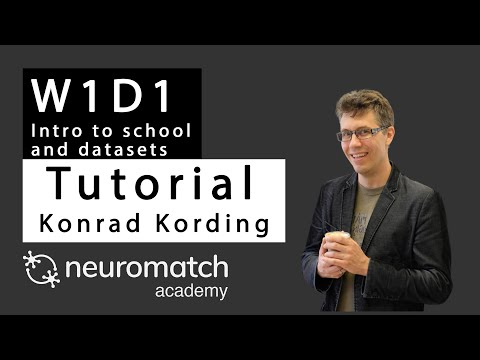

In [1]:
#@title Video: “Why” models
from IPython.lib.display import IFrame
class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
        self.id=id
        src = "//player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
        super(BiliVideo, self).__init__(src, width, height, **kwargs)

video = BiliVideo(id='BV1F5411e7Wp', width=854, height=480, fs=1)
print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
video

### Exercise: Probabilty Mass Function

Your second exercise is to implement a method that will produce a probability mass function from an array of ISI bin counts.

To verify your solution, we will compute the probability distribution of ISIs from real neural data taken from the Steinmetz dataset.

In [14]:
neuron_idx = 283
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(0, 0.25, n_bins + 1)
counts, _ = np.histogram(isi, bins)

In [15]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  ###########################################################################
  ## TODO for students: compute the probability mass function from ISI counts 
  ###########################################################################
  raise NotImplementedError("Student excercise: compute the PMF from ISI counts")

# Uncomment once you complete the function
# pmf = pmf_from_counts(counts)
# histogram(pmf, bins, ax_args={
#   'title': f"Neuron {neuron_idx}",
#   'xlabel': "Inter-spike interval (s)",
#   'ylabel': "Probability mass",
# })

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D1_ModelTypes/solutions/W1D1_Tutorial3_Solution_f3b21477.py)

*Example output:*

<img alt='Solution hint' align='left' width=432 height=297 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D1_ModelTypes/static/W1D1_Tutorial3_Solution_f3b21477_0.png>



Video available at https://youtube.com/watch?v=cyBu1pEGOh4


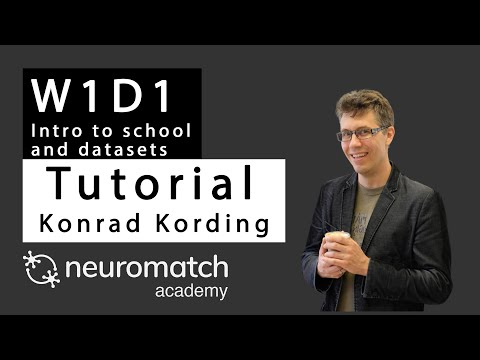

In [17]:
#@title Video: Calculating entropy of a probability distribution
from IPython.lib.display import IFrame
class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
        self.id=id
        src = "//player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
        super(BiliVideo, self).__init__(src, width, height, **kwargs)

video = BiliVideo(id='BV1F5411e7Wp', width=854, height=480, fs=1)
print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
video

Now that we have the probability distribution for the actual neuron spiking activity, we can calculate its entropy.

In [18]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


### Data Exploration

We can combine the above distribution plot and entropy calculation with an interactive widget to explore how the different neurons in the dataset vary in spiking activity and relative information.

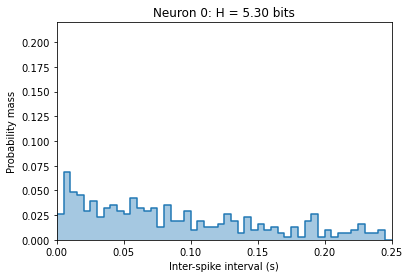

In [19]:
#@title Steinmetz Neuron Information Explorer

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)


@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(0, 0.25, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)
  
  ymax = max(0.2, np.max(pmf))
  histogram(pmf, bins, ax_args={
    'title': f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits",
    'xlabel': "Inter-spike interval (s)",
    'ylabel': "Probability mass",
    'ylim': [0, ymax]
  })

Video available at https://youtube.com/watch?v=-eGFd7E_smA


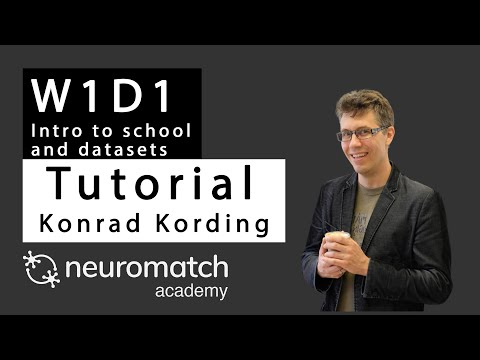

In [20]:
#@title Video: Summary of “why” models
from IPython.lib.display import IFrame
class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
        self.id=id
        src = "//player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
        super(BiliVideo, self).__init__(src, width, height, **kwargs)

video = BiliVideo(id='BV1F5411e7Wp', width=854, height=480, fs=1)
print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
video

## Appendix

### The foundations for Entropy

**Shannon** [ref] began with three criteria for a function $H$ defining the entropy of a discrete distribution of probability masses $p_i\in p(X)$ over the points $x_i\in X$:
1. $H$ should be continuous in the $p_i$. 
  - That is, $H$ should change smoothly in response to smooth changes to the mass $p_i$ on each point $x_i$.
2. If all the points have equal shares of the probability mass, $p_i=1/N$, $H$ should be a non-decreasing function of $N$. 
  - That is, if $X_N$ is the support with $N$ discrete points and $p(x\in X_N)$ assigns constant mass to each point, then $H(X_1) < H(X_2) < H(X_3) < \dots$
3. $H$ should be preserved by (invariant to) the equivalent (de)composition of distributions.
  - For example [from Shannon's paper] if we have a discrete distribution over three points with masses $(\frac{1}{2},\frac{1}{3},\frac{1}{6})$, then their entropy can be represented in terms of a direct choice between the three and calculated $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})$. However, it could also be represented in terms of a series of two choices: 
    1. either we sample the point with mass $1/2$ or not (_not_ is the other $1/2$, whose subdivisions are not given in the first choice), 
    2. if (with probability $1/2$) we _don't_ sample the first point, we sample one of the two remaining points, masses $1/3$ and $1/6$.
    
    Thus in this case we require that $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})=H(\frac{1}{2},\frac{1}{2}) + \frac{1}{2}H(\frac{1}{3}, \frac{1}{6})$

There is a unique function which satisfies these 3 requirements: [the function is unique up to scaling by a linear factor]

\begin{align}
  H_b(X) &= -\sum_{x\in X} p(x) \log_b p(x)
\end{align}

Where the base of the logarithm $b>1$ controls the units of entropy. The two most common cases are $b=2$ for units of _bits_, and $b=e$ for _nats_.

We can view this function as the expectation of the self-information over a distribution:

$$H_b(X) = \mathbb{E}_{x\in X} \left[I_b(x)\right]$$

$$I_b(x)=-\log_b p(x)$$

Self-information is just the negative logarithm of probability, and is a measure of how surprising an event sampled from the distribution would be. Events with $p(x)=1$ are certain to occur, and their self-information is zero [as is the entropy of the distribution they compose] meaning they are totally unsurprising. The smaller the probability of an event, the higher its self-information, and the more surprising the event would be to observe. 
